(data_processing)=
# Data processing

In [1]:
# %load_ext watermark
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import rpy2
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import beta
from scipy.stats import multinomial


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from myst_nb import glue
from slugify import slugify

from typing import List



from rpy2.robjects.packages import importr

import plastockconf as psc
import plastock as pstk

from plastockconf import name_zones, name_frequentation, name_situation
from plastockconf import name_substrate, name_distance, table_css_styles, table_css_styles_top

from plastock import add_table_to_page, capitalize_x_tick_labels, capitalize_x_and_y_axis_labels, capitalize_legend_components, attribute_summary

import reportclass as rc

section = "A"
page = "5"

label = f'Table {section}{page}-'

def make_exportable(data, file_name, cmap='YlOrBr'):
    data.fillna(0, inplace=True)
    fig, ax = plt.subplots(figsize=(12,8))
    sns.heatmap(data=data, vmin=0, vmax=1, cmap=cmap, annot=True, fmt='.2', annot_kws={'size':10}, ax=ax, cbar=False)
    plt.tight_layout()
    ax.tick_params(which='both', axis='both', bottom=False, left=False)
    plt.savefig(file_name, dpi=300)

    plt.close()

glue('blank_caption', " ", display=False)

## Déchets sauvages

__Cette méthode s'applique aux données sur les déchets de plage, mais pas aux données sur les microplastiques__

### Position

Les inventaires des déchets de plage menées précédemment sur le lac considéraient la plage comme une unité à part entière. Dans Plastock, chaque plage a été divisée en deux sections, la ligne d'eau et la plage sèche. Pour comparer les données de Plastock aux résultats précédents et à d'autres études de ce type, les résultats de Plastock doivent être transformés en une section pour une plage. En d'autres termes, nous devons combiner la surface des deux sections pour chaque échantillon. Le nombre d'objets par échantillon est ensuite divisé par la surface commune des deux sections.

### Substrat

Certains échantillons ont des substrats différents pour chaque section de chaque plage. Les sections doivent avoir le même substrat pour chaque section si nous voulons compter la plage comme une unité entière. Pour les douze échantillons qui répondent à ce critère, le substrat a été modifié de 4 à 2 (du gravier au sable grossier).

### Objets

La variété des objets trouvés lors de chaque enquête est autant le reflet des déchets sur le terrain que du temps alloué aux participants pour compter, trier et identifier chaque objet collecté. Par conséquent, les seuls codes ou objets pris en considération sont ceux qui ont été identifiés pendant Plastock. Les données historiques sont filtrées pour les mêmes codes.

#### Combinaison d'objets similaires

Certaines catégories d'objets sont combinées. Cela signifie que nous modifions le code de certains éléments pour refléter les tendances de l'échantillonnage et tenir compte des différentes interprétations du protocole. Le tableau suivant résume la façon dont les codes sont combinés :

1. Gfrags: g80, g79, g78, g77, g76, g75
2. Gfoams: G81, G82, G76
3. Gcaps: G21, G22, G23, G24

Gfrags comprend toutes les formes de plastiques fragmentés de plus de 5 mm, Gfoams toutes les tailles de polystyrène expansé et Gcaps tous les bouchons en plastique et les anneaux en plastique qui accompagnent chaque bouchon.

In [2]:
# ! read in data !
# survey data
new_data = pd.read_csv("data/end_pipe/macro_current.csv")

# the position, substrate, time, area, length for each sample in the data
# ! there are samples that have different substrates on the same sample_id.!
# that is position 1 has a different substrate than position 2. for litter 
# data and comparing to previous results this is unimportant. The value to
# compare is the total survey divided by the length or the area. This needs
# to be accounted for and changes made to certain samples.
beach_data = pd.read_csv("data/end_pipe/pstock_beaches_current.csv")


# the feature columns of the survey data that are not dependent on the
# position or substrat variables. they are indexed on the Plage column
# one row for each sample location
beach_datax = pd.read_csv("data/end_pipe/asl_beaches.csv").set_index('Plage')

# The code definitions
codes = pd.read_csv('data/end_pipe/codes.csv').set_index('code')

# the regional labels for each survey location
regions = pd.read_csv("data/end_pipe/lac_leman_regions.csv")
regions.set_index('slug', drop=True, inplace=True)

# the city name of the survey locations
city_map = pd.read_csv('data/end_pipe/city_map.csv')
city_map.set_index('slug', inplace=True)

# translation of common terms into french, german and english
language_maps = rc.language_maps()

new_column_names = {
    "Position":"position",
    "Substrat":"substrat",
    "Date":"date",
    "Code":"code",
    "Quantité":"quantité",
    "Aire":"area"
}

# import data and assign new column names and sample_id
# the sample_id is the tuple (location, date). Each row
# is a unique combinantion of sample_id and code
work_data = new_data[["Plage", *new_column_names.keys()]].copy()
work_data.rename(columns=new_column_names, inplace=True)
work_data["slug"] = work_data.Plage.apply(lambda x: slugify(x))
work_data["échantillon"] = list(zip(work_data.slug, work_data['date']))
work_data['date'] = pd.to_datetime(work_data["date"], format="mixed", dayfirst=True)
work_data.dropna(inplace=True)

# type the columns
work_data[["position", "substrat"]] = work_data[["position", "substrat"]].astype("int")
work_data['échantillon'] = work_data['échantillon'].astype(str)

In [3]:
voi = "substrat"
vals = "pcs/m²"
code = "G27"
loc_dates_t = ["('clarens', '16.01.2022')", "('amphion', '01.02.2022')"]

gfrags_c = codes.loc[codes.parent_code == 'Gfrags'].index

start_amph_s = new_data[(new_data.Plage == "Amphion")&(new_data["Date"] == "01.02.2022")&(new_data.Code == "G27")]
start_amph_c = new_data[(new_data.Plage == "Amphion")&(new_data["Date"] == "01.02.2022")&(new_data.Code.isin(gfrags_c))]
start_clarens_s = new_data[(new_data.Plage == "Clarens")&(new_data["Date"] == '16.01.2022')&(new_data.Code == "G27")]
start_clarens_c = new_data[(new_data.Plage == "Clarens")&(new_data["Date"] == '16.01.2022')&(new_data.Code.isin(gfrags_c))]

In [4]:
start_data = pd.concat([start_amph_s, start_amph_c, start_clarens_c, start_clarens_s])
start_data['pcs/m²'] = start_data["Quantité"]/start_data["Aire"]
# start_data.loc[start_data.Code.isin(gfrags_c), 'Code'] = 'Gfrags'
sd = start_data[["Plage", "Aire", "Position", "Substrat", "Date", "Code", "Quantité", 'pcs/m²']].copy()
sd.reset_index(inplace=True, drop=True)

display_columns = ["Plage", "Date", "Position", "Substrat", "Aire",  "Code", "Quantité", "pcs/m²"]

caption = f"<b>{label}1 :</b> Les résultats de l'échantillon avant la combinaison des codes, des substrats et de la position"
sd = sd[display_columns].style.set_table_styles(table_css_styles).format(**psc.format_kwargs).set_caption(caption).hide(axis="index")

glue("start_data", sd, display=False)

In [5]:
# ! locate all the duplicate values by sample id and area !
# this gives a data frame that has the position and area for
# each sample_id
total_area_dup = work_data.drop_duplicates(['échantillon', 'area'])

# ! combine the surface areas of the position vectors !
# sum of the areas for each position at each sample
# use the sample_id as index and sum the areas for each postition at each sample
total_area = total_area_dup.groupby(['échantillon', 'Plage'], as_index=False).area.sum()

# sum of the areas for each position at each sample
# use the sample_id as index and sum the areas for each postition at each sample
total_area = total_area[['échantillon', 'area']].set_index('échantillon', drop=True)

In [6]:
# apply the total area to the work_data, index on sample_id
work_data['area_c'] = work_data['échantillon'].apply(lambda x: total_area.loc[x])
work_data['area'] = work_data.area_c
work_data.drop('area_c', axis=1, inplace=True)
# the code total per sample with the combined area
work_data = work_data.groupby(['échantillon', 'Plage', 'substrat', 'date', 'area','slug', 'quantité', 'code'], as_index=False)['quantité'].sum()
work_data.reset_index(inplace=True, drop=True)

In [7]:
mask = (work_data["échantillon"].isin(loc_dates_t))&(work_data.code.isin([*gfrags_c, code]))

display_columns = ["échantillon", "Plage", "Substrat", "Aire",  "Code", "Quantité"]
d = "pcs/m²"

test = work_data[mask].copy()
test = test.rename(columns={"substrat":"Substrat", "area":"Aire", "date":"Date", "code":"Code", "quantité":"Quantité"})
test = test[display_columns].copy()
# test.reset_index(inplace=True, drop=True)
caption = f"<b>{label}2 :</b> La variable position est supprimée et les surfaces sont combinées pour chaque position de chaque échantillon. Cependant, le substrat à Clarens n'est pas corrigé."
sd_2 = test.style.set_table_styles(table_css_styles).format(**psc.format_kwargs).set_caption(caption).hide(axis='index')
glue("start_data_2", sd_2, display=False)


In [8]:
# the code total per sample with the combined area
work_data = work_data.groupby(['échantillon', 'Plage', 'substrat', 'date', 'area','slug', 'code'], as_index=False)['quantité'].sum()

# add the regional component
work_data['region'] = work_data.slug.apply(lambda x: regions.loc[x, 'alabel'])

work_data = work_data.groupby(['échantillon', 'Plage', 'substrat', 'date', 'area','slug', 'quantité', 'code'], as_index=False)['quantité'].sum()
# get the pcs/m²  for each object at each sample
work_data['pcs/m²'] = work_data['quantité']/work_data.area

In [9]:
# ! there are samples that have different substrates on the same sample_id.!
# there should be one substrate per sample_id. Identify the locations that have duplicate values
some_data = work_data.copy()
groupby = ['échantillon', voi]
data = some_data.groupby(groupby, as_index=False)[vals].sum()

# the samples with more than one substrate
dd = data[data['échantillon'].duplicated()].copy()
# select all the duplicated sample_ids from the work_data
duplicated = work_data[work_data['échantillon'].isin(dd['échantillon'].unique())].copy()
# select all the duplicated sample_ids from the work_data
# change the substrat to [2]
duplicated['substrat'] = 2 

# select all the values that are not duplicated
not_duplicated = work_data[~(work_data['échantillon'].isin(dd['échantillon'].unique()))].copy()

# put it back together again
work_data = pd.concat([duplicated, not_duplicated])

In [10]:
mask = (work_data["échantillon"].isin(loc_dates_t))&(work_data.code.isin([*gfrags_c, code]))

display_columns = ["échantillon", "Plage", "Substrat", "Aire",  "Code", "Quantité", "pcs/m²"]

test = work_data[mask].copy()
test = test.rename(columns={"substrat":"Substrat", "area":"Aire", "date":"Date", "code":"Code", "quantité":"Quantité"})
test = test[display_columns].copy()

caption = f"<b>{label}3 :</b> Après avoir combiné les codes et supprimé la variable de la position, il reste des codes en double pour l'échantillon de Clarens."
sd_3 = test.style.set_table_styles(table_css_styles).format(**psc.format_kwargs).set_caption(caption).hide(axis="index")
glue("start_data_3", sd_3, display=False)

In [11]:
# ! valid codes and definitions !
# plastock did not use the same inventory as iqaasl
# here we select only the codes in the plastock inventory
pcodes = work_data.code.unique()

# identify and remove codes for which there is no defintion
# if the code is not defined then it can not be used
t = [x for x in pcodes if x not in codes.index]
wd_ni = work_data[~work_data.code.isin(t)].copy()

# ! aggregating to Gfrags, Gcaps and Gfoams !
# these items are not well divided into the composite subgroups
# for example people often know what a cap is, but whether it 
# comes from a drink bottle or other type is not well considered
# we combine the subcategories into more comprehensive groups.
ti = rc.use_gfrags_gfoams_gcaps(wd_ni, codes)

In [12]:
# ! groupby the sample id and code otherwise there are duplicate codes
# after aggregating to Gfrags etc..
work_data = ti.groupby(['échantillon', 'Plage', 'substrat', 'date', 'area', 'slug', 'code'], as_index=False).agg({'quantité':'sum'})
work_data['pcs/m²'] = work_data['quantité']/work_data['area']

# accounting for objects not found at a sample:
# the codes that were indentified are the unique codes
# in the set of data, they are the 'inventory'
codes_ip = work_data.code.unique()
# the unique samples by id
loc_dates = work_data['échantillon'].unique()

# a copy for itterating
wd = work_data.copy()

In [13]:
start_data.loc[start_data.Code.isin(gfrags_c), 'Code'] = 'Gfrags'

display_columns = ["Plage", "Date", "Position", "Substrat", "Aire",  "Code", "Quantité", "pcs/m²"]

start_data = start_data.groupby(["Plage", "Date", "Aire", "Code"], as_index=False)["Quantité"].sum()

start_data["pcs/m²"] = start_data["Quantité"]/start_data.Aire
sd_x = start_data.groupby(["Plage", "Date", "Code"], as_index=False)["pcs/m²"].mean()

caption =  f"<b>{label}5 :</b> La densité de l'échantillon si les zones et les substrats ne sont pas combinés pour chaque échantillon." 
sd_x = sd_x.style.set_table_styles(table_css_styles).format(**psc.format_kwargs).set_caption(caption).hide(axis="index")
glue("start_data_4", sd_x, display=False)

In [14]:
# a copy for itterating
wd = work_data.copy()

rows = []
for a_loc in loc_dates:
    r = wd.loc[wd['échantillon'] == a_loc].copy()
    r.reset_index(inplace=True, drop=True)
    
    t = r.loc[0][['échantillon', 'Plage', 'substrat', 'date', 'area', 'slug']].values
    asamp = [x for x in t]
    used_codes = r.code.unique()
    unused = [x for x in codes_ip if x not in used_codes]
    for element in unused:
        arow = [*asamp, element, 0, 0]
        rows.append(arow)
        

# now all the data has the same number of records per sample
# for each sample we can now say what was found and what was
# not found with respect to all the results
work_x = pd.DataFrame(rows, columns=['échantillon', 'Plage', 'substrat', 'date', 'area', 'slug', 'code', 'quantité', 'pcs/m²'])
work_data = pd.concat([work_x, work_data])


# add the regional component
work_data['region'] = work_data.slug.apply(lambda x: regions.loc[x, 'alabel'])

In [15]:
mask = (work_data["échantillon"].isin(loc_dates_t))&(work_data.code.isin(["Gfrags", "G27"]))
display_columns = ["échantillon", "Plage", "Substrat", "Aire",  "Code", "Quantité", "pcs/m²"]
test = work_data[mask].copy()
test = test.rename(columns={"substrat":"Substrat", "area":"Aire", "date":"Date", "code":"Code", "quantité":"Quantité"})
test = test[display_columns].copy()

caption =  f"<b>{label}4 :</b> The density of sample if the areas are combined. The result for each sample is the sum of the different results for the different positions and substrates for each sample."
sd_5 = test.style.set_table_styles(table_css_styles).format(**psc.format_kwargs).set_caption(caption).hide(axis="index")
glue("start_data_5", sd_5, display=False)

In [16]:
work_data.to_csv('data/end_pipe/macro_data_msquared.csv', index=False)
work_data_example = work_data.copy()

### Exemple

#### Mètres carrés

Pour illustrer les changements apportés aux données, considérons deux échantillons et deux codes (G27, Gfrags). Le premier échantillon est Amphion le 2022-02-01 et le second est Clarens le 2022-01-16. À Amphion, il y a plusieurs valeurs pour les mêmes codes le même jour. Il en va de même pour Clarens, mais à Clarens, il y a également deux substrats pour la plage. Notez que les codes G78 et G79 font partie du code combiné Gfrags.

```{glue} start_data
```

Pour combiner les données, nous devons additionner les surfaces pour chaque échantillon, appliquer la nouvelle surface à tous les comptages d'objets pour cet échantillon et ce jour, et supprimer la variable de position. Pour Amphion, la surface totale est de 342 + 98 = 440 m², pour Clarens 273 + 67 = 340 m².

```{glue} start_data_2
``` 

Après avoir combiné tous les totaux de codes pour chaque échantillon et remplacé le substrat 4 par le substrat 2 dans toutes les localités qui ont des valeurs de substrat distinctes pour la position, nous nous retrouvons encore avec des codes en double sur un échantillon.

```{glue} start_data_3
``` 

Dans la dernière étape, les codes qui doivent être combinés (G78 et G79) sont placés sous un seul code et les données sont agrégées à l'identifiant de l'échantillon (date et lieu de l'échantillon).  

```{glue} start_data_5
```

#### La différence

Si les surfaces des positions ne sont pas combinées, les valeurs attendues sont beaucoup plus faibles. En effet, nous sommes obligés de prendre la moyenne de la densité des deux positions et des substrats pour chaque échantillon. 

```{glue} start_data_4
``` 

__Problème de communication :__ Cela peut être difficile à communiquer. La moyenne pour une région est la moyenne de la densité totale par échantillon. C'est-à-dire le nombre total d'objets divisé par la surface totale. Cependant, dans ce cas, la moyenne de la région est la moyenne des moyennes par échantillon.

Cela signifie que la médiane d'une région serait la médiane de la moyenne des moyennes par échantillon. 


#### Mètres linéaires

L'opération de transformation des données en mètres linéaires est différente. Pour convertir toutes les plages en une seule section, nous abandonnons la variable superficie et la remplaçons par les données de longueur fournies. La longueur est la même pour les deux sections de chaque plage (les surfaces sont différentes), nous avons donc divisé la somme de tous les objets par la longueur donnée pour l'échantillon. Ce processus est conforme à la norme décrite dans le guide de surveillance des déchets marins.

In [17]:
# reading in data
new_datai = pd.read_csv("data/end_pipe/macro_current.csv")
beach_data = pd.read_csv("data/end_pipe/pstock_beaches_current.csv")


# adding the lenght of each sample to the results
length_key = beach_data[["Plage","length"]].drop_duplicates("Plage").set_index("Plage")
work_datai = new_datai[["Plage", *new_column_names.keys()]].copy()
work_datai.rename(columns=new_column_names, inplace=True)
work_datai["length"] = work_datai.Plage.apply(lambda x: length_key.loc[x, "length"])

# making a sample id from the location and date
work_datai["slug"] = work_datai.Plage.apply(lambda x: slugify(x))
work_datai["echantillon"] = list(zip(work_datai.slug, work_datai['date']))
work_datai['date'] = pd.to_datetime(work_datai["date"], format="mixed", dayfirst=True)
work_datai.dropna(inplace=True)

# defining the data type of columns
work_datai[["position", "substrat"]] = work_datai[["position", "substrat"]].astype("int")

# changing the column name to human readable
work_datai['échantillon'] = work_datai['echantillon']
work_datai.drop(['echantillon'], inplace=True, axis=1)

# removing the position variable from data and
# grouping by sample id and code to get the total per sample per code
work_datai = work_datai.groupby(['échantillon', 'Plage', 'substrat', 'date', 'length', 'slug', 'code'], as_index=False).agg({'quantité':'sum'})

# divide that by length
work_datai['pcs/m'] = work_datai['quantité']/work_datai['length']

# add the region
work_datai['region'] = work_datai.slug.apply(lambda x: regions.loc[x, 'alabel'])

In [18]:
# ! combining the substrates for beaches where there are two substrates !
voi = 'substrat'
vals = "pcs/m"
some_data = work_datai.copy()
groupby = ['échantillon', voi]
data = some_data.groupby(groupby, as_index=False)[vals].sum()

# these are the duplicate values that need to be changed
dd = data[data['échantillon'].duplicated()].copy()

duplicated = work_datai[work_datai['échantillon'].isin(dd['échantillon'].unique())].copy()
duplicated['substrat'] = 2 

# notduplicated
not_duplicated = work_datai[~(work_datai['échantillon'].isin(dd['échantillon'].unique()))].copy()

# put it back to gether again
work_datai = pd.concat([duplicated, not_duplicated])

# groupby the new substrat values and calculate pcs/m
work_datai = work_datai.groupby(['échantillon', 'Plage', 'region', 'substrat', 'date', 'length', 'slug', 'code'], as_index=False).agg({'quantité':'sum'})
work_datai['pcs/m'] = work_datai['quantité']/work_datai['length']

In [19]:
# ! defining the total inventory of the current data !
# accounting for objects not found at a sample:
# the codes that were indentified at least once = inventory
# defining the components of the inventory
codes_ip = work_datai.code.unique()

# the unique samples
loc_dates = work_datai['échantillon'].unique()

# a copy for itterating
wd = work_datai.copy()

# for each sample (échantillon) indentify the codes that were not
# found by indentifying all the codes that were found in all surveys
# and removing the codes that were not identified at that sample.
# for each unidentified code per sample, add a row with the sample
# id and the code. give the row a quantity of zero.
rows = []
for a_loc in loc_dates:
    r = wd.loc[wd['échantillon'] == a_loc].copy()
    r.reset_index(inplace=True, drop=True)
    
    t = r.loc[0][['échantillon', 'Plage', 'region', 'substrat', 'date', 'length', 'slug']].values
    asamp = [x for x in t]
    used_codes = r.code.unique()
    unused = [x for x in codes_ip if x not in used_codes]
    for element in unused:
        arow = [*asamp, element, 0, 0]
        rows.append(arow)
        

work_x = pd.DataFrame(rows, columns=['échantillon', 'Plage', 'region', 'substrat', 'date', 'length', 'slug', 'code', 'quantité', 'pcs/m'])
work_datai = pd.concat([work_x, work_datai])

work_datai.to_csv("data/end_pipe/macro_data_linearm.csv", index=False)

## Analyse et inférence

We used two methods of approximation to infer the expected results: _Random Forest Regression_ and _Bayesian grid approximation_. 

### Random Forest Regression
1. **Type of Model**: Random Forest is an ensemble learning method, particularly used for regression (and classification) tasks.
2. **How it Works**: It operates by constructing multiple decision trees during training and outputting the mean prediction of the individual trees for regression tasks.
3. **Key Features**:
   - **Handling Non-Linearity**: It can handle non-linear relationships between features and the target variable well.
   - **Feature Importance**: Provides insights into which features are most important in predicting the target variable.
   - **Overfitting**: Generally, less prone to overfitting compared to individual decision trees.
   - **Flexibility**: Can be used for both categorical and continuous input and output variables.

### Bayesian Grid Approximation
1. **Type of Model**: This approach is grounded in Bayesian statistics. It's not a specific model but a method for estimating or approximating the posterior distribution of model parameters.
2. **How it Works**: Involves specifying a prior distribution for the parameters, a likelihood function based on the data, and then using computational techniques (like grid approximation) to estimate the posterior distribution of the parameters.
3. **Key Features**:
   - **Uncertainty Estimation**: Provides a probabilistic interpretation and a way to estimate uncertainty in predictions.
   - **Prior Knowledge**: Incorporates prior knowledge or beliefs about the parameters through the prior distribution.
   - **Computationally Intensive**: For high-dimensional parameter spaces, grid approximation can become impractical.
   - **Flexibility**: Can be applied to a wide range of models, including linear models, hierarchical models, etc.

### Key Differences
- **Fundamental Approach**: Random Forest is a machine learning algorithm based on decision trees, while Bayesian Grid Approximation is a statistical method for estimating parameter distributions.
- **Output**: Random Forest provides a single predictive model. Bayesian methods provide a distribution of possible models, giving a sense of uncertainty.
- **Complexity and Computation**: Random Forest is generally straightforward and less computationally intensive compared to Bayesian methods, especially for large datasets or models with many parameters.
- **Interpretability**: Random Forests can be less interpretable due to the ensemble nature of many trees, whereas Bayesian methods offer probabilistic interpretations that can be insightful but might require a deeper statistical understanding.

Each method has its strengths and is suitable for different kinds of problems and data sets. The choice between them depends on the specific requirements of the analysis, such as the need for uncertainty quantification, computational resources, and the nature of the data.

In [20]:
# reading in data
# new_data = pd.read_csv("data/end_pipe/macro_current.csv")
work_data = pd.read_csv("data/end_pipe/macro_data_linearm.csv")
beach_data = pd.read_csv("data/end_pipe/pstock_beaches_current.csv")

# historical data
hist_leman = pd.read_csv("data/end_pipe/hist_leman.csv")
# ghi = pd.read_csv('data/end_pipe/iqaasl.csv')
hiqaasl = hist_leman[hist_leman.project == "IQAASL"].copy()
hiqaasl.rename(columns={"sample_id":"loc_date", "location":"slug", 'pcs/m':'pcs_m'}, inplace=True)
iq_cols = ['loc_date', 'date', 'slug', 'code', 'quantity', 'city', 'feature_name', 'feature_type', 'parent_boundary', 'pcs_m', 'project']

ghi = hiqaasl[iq_cols].copy()



# most recent results not plastock
ssp=pd.read_csv('data/end_pipe/swt_all.csv')

# the independent variables are in asl_beaches file
beach_data_f = pd.read_csv("data/end_pipe/asl_beaches.csv").set_index('Plage')

# code definitions
codes = pd.read_csv('data/end_pipe/codes.csv').set_index('code')

# add the regional component
# the regional labels for each survey location
regions = pd.read_csv("data/end_pipe/lac_leman_regions.csv")
regions.set_index('slug', drop=True, inplace=True)

# the city designation is used for reporting
# the city name of the survey locations
city_map = pd.read_csv('data/end_pipe/city_map.csv')
city_map.set_index('slug', inplace=True)

codes_ip = work_data.code.unique()

# !important formatting data for use with IQAASL
# when combined with previous data there are duplicate location names
# the locations in plastock data that have the same name as iqaasl data
# need to be changed so we can use the reporting scheme from IQAASL
change_names = ['preverenges', 'tolochenaz', 'versoix', 'vidy', 'cully']

plastock_cols = ['loc_date', 'date','slug','region', 'code', 'quantity', 'city', 'feature_name', 'feature_type','parent_boundary', 'pcs_m']
features = ['frequentation', 'situation', 'orientation', 'distance']

changeus = work_data[work_data.slug.isin(change_names)].copy()
donotchange = work_data[~work_data.slug.isin(change_names)].copy()

new_slug = {
    'cully': 'cully-p',
    'preverenges': 'preverenges-p',
    'tolochenaz': 'tolochenaz-p',
    'versoix':'versoix-p',
    'vidy': 'vidy-p'}

# they have the same name as locations in iqaasl
changeus['new_slug'] = changeus.slug.apply(lambda x: new_slug[x])
changeus['slug'] = changeus.new_slug
changeus.drop('new_slug', inplace=True, axis=1)

# the plastock data with the converted names
wd_nn = pd.concat([changeus, donotchange])

# # plastock did not use the same inventory as iqaasl
# # here we select only the codes in the plastock inventory
# pcodes = wd_nn.code.unique()

# identify and remove codes for which there is no defintion
# if the code is not defined then it can not be used
t = [x for x in codes_ip if x not in codes.index]
wd_ni = wd_nn[~wd_nn.code.isin(t)].copy()


# ! aggregating plastic caps, fragmented plastics, fragmented foams !
# these items are not well divided into the composite subgroups
# for example people often know what a cap is, but whether it 
# comes from a drink bottle or other type is not well considered
# we combine the subcategories into more comprehensive groups.
ti = rc.use_gfrags_gfoams_gcaps(wd_ni, codes)


# formatting data for reporting
# aggregate along all land-use and topo variables.
ti = ti.groupby(['échantillon', 'Plage', 'region', 'date', 'substrat', 'length', 'slug', 'code'], as_index=False).agg({'quantité':'sum'})

# !combinining with previous results!
# these are the default arguments for the report class
# the language maps gives the code definitions in english, german and french
# the top_label asserts the top level aggregation for the set of data defined by
# start, end dates and feature_name. These arguments are for the plastock data
language_maps = rc.language_maps()
top_label= ['feature_name', 'lac-leman']

# the default language is english in the report column class
# there are column names that need to be changed
new_names = {'échantillon': 'loc_date', 'pcs/m': 'pcs_m'}
ti.rename(columns={**new_names,'quantité': 'quantity'}, inplace=True)

# define the pcs/m column and the data to merge
ti['pcs_m'] = ti.quantity/ti.length

# adding and renaming columns according to reportclass requirements
# these values can be indexed on the IQAASL data
ti['city'] = ti.slug.apply(lambda x: city_map.loc[x])
ti['feature_name'] = 'lac-leman'
ti['feature_type'] = 'l'
ti['parent_boundary'] = 'rhone'

# ! adding feature columns to survey data !
# they can be merged on the Plage column and the index
# these are used for modeling
env_plastock = ti.merge(beach_data_f[features], left_on='Plage', right_index=True)
env_plastock = env_plastock[[*plastock_cols, *features, 'substrat']]

In [21]:
def name_the_new_distance(x, less='<= 500 m', more = '> 500 m'):
    if x == 1:
        return less
    else:
        return more

def name_the_new_freq(x, new):
    if x <= 2:
        return new
    else:
        return 'Elévée'


# the feature variables are added to the work_data
ti = work_data.copy()
features = ['frequentation', 'situation', 'orientation', 'distance']

# they can be merged on the Plage column and the index
env_plastock = ti.merge(beach_datax[features], left_on='Plage', right_index=True)

# ! creation of composite variables !
t_and_f = env_plastock.loc[:, ['échantillon', 'slug','date','code', 'pcs/m', 'quantité', 'frequentation', 'situation', 'distance', 'substrat', 'region']].copy()

# the substrat and distance features are being combined
# the two lowest and the two highest of each group are being combined
# substrat is a matter of combining different granularities. They are being grouped as
# sand and gravel.
# distance is now grouped by locations either less than or equal to 500 meters
t_and_f.loc[t_and_f.substrat <= 2, 'substrat'] = 1
t_and_f.loc[t_and_f.substrat > 2, 'substrat'] = 2
t_and_f.loc[t_and_f.distance <= 2, 'distance'] = 1
t_and_f.loc[t_and_f.distance > 2, 'distance'] = 2
t_and_f.loc[t_and_f.frequentation <= 2, 'frequentation'] = 2

# ! the data used in the models !
f_combi = t_and_f.copy()

f_combi.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)

In [22]:
grid_val_index = np.linspace(0, 19.99, 2000)
groupby_columns = ['sample_id', 'location', 'date', 'city', 'orchards', 'vineyards', 'buildings', 'forest',
                   'undefined', 'public_services', 'streets']


In [23]:
# # the prior data from surveys
# iqaasl_prior = report_iq_pk.w_df[report_iq_pk.w_df.project == "IQAASL"].copy()
# iq_p = iqaasl_prior.groupby(['loc_date', 'project'], as_index=False).pcs_m.sum()
# iq_p['top'] = 1

# iq_prior = pstk.calculate_likelihood(aggregated_data=iq_p, bin_density_column='top', pcs_column='pcs_m', grid_range=grid_val_index, bins=[1])
# iq_prior.rename(columns={'Likelihood_1':'Bin_1'}, inplace=True)

# col = 'top'
# pcs_col = 'pcs_m'
# grid_range = grid_val_index
# bins = [1]

# # assuming know prior knowledge
# beta_prior = pstk.calculate_beta_prior(grid_range=grid_range, bin_density_numbers=[1])

# test_x = f_combi.copy().groupby(cols, as_index=False).pcs_m.sum()
# test_x['top'] = 1

# grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

In [24]:
# # posterior uninformed
# post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# # posterior informed
# post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# # samples
# sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
# s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

# caption = 'Toutes les conditions'

# test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, s_iqp, caption=caption)
# glue('q-tous-b', test_grid_quants, display=False)
# title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: toutes les conditions,  grid approximation, prior = IQAASL'

# pstk.plot_histogram(s_iqp, test_x.pcs_m.values, title=title, reference='toutes-gapprox', display=False)

In [25]:
# col = 'substrat'
# pcs_col = 'pcs_m'
# grid_range = grid_val_index
# bins = [2]

# test_xi = f_combi[(f_combi['substrat'] == 2)].copy()
# test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()


# grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# # posterior uninformed
# post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# # posterior informed
# post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# # samples
# sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
# s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

# caption = 'Graviers'

# test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, sample_totals, caption=caption)
# glue('q-gravier-b', test_grid_quants, display=False)
# title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Graviers, grid approximation, prior = IQAASL'

# pstk.plot_histogram(sample_totals, test_x.pcs_m.values, title=title, reference='graviers-gapprox', display=False)

In [26]:
# col = 'situation'
# pcs_col = 'pcs/m²'
# grid_range = grid_val_index
# bins = [2]

# test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['distance'] == 1)].copy()
# test_x = test_xi.groupby(cols, as_index=False)[pcs_col].sum()


# grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# # posterior uninformed
# post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# # samples
# sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())

# caption = 'Ville et distance <= 500 m'

# test_grid_quants = pstk.makeqdf(test_x[pcs_col].values, sample_totals, caption=caption)
# glue('q-ville-d1-sa', test_grid_quants, display=False)
# title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Ville et distance <= 500 m, grid approximation, '

# pstk.plot_histogram(sample_totals, test_x[pcs_col].values, title=title, reference='v-d1-sa', display=False)

In [27]:
# fig, ax = plt.subplots()
# sns.scatterplot(data=post_grid_pstock1, x="X", y="Bin_1", c='black', alpha=0.4, label="all")
# sns.scatterplot(data=post_grid_pstock2, x="X", y="Bin_1", alpha=0.4, c='magenta', label='model')
# sns.scatterplot(data=post_grid_pstock3, x="X", y="Bin_1", alpha=0.4, c='dodgerblue', label='model')

### Analyse factorielle de données mixtes

L'ACP n'est pas recommandée si l'on utilise des types de données mixtes. Nous suivrons ici la méthode recommandée. Nous poursuivrons ensuite avec une ACP traditionnelle. Dans ce cas particulier, l'augmentation de la dimensionnalité causée par les variables nominales peut ne pas être un problème.

_"L’introduction simultanée de variables quantitatives et qualitatives (donnéesdites mixtes) en tant qu’éléments actifs d’une même analyse factorielle est une problématique fréquente. La méthodologie usuelle consiste à transformer les variables quantitatives en qualitatives en découpant en classes leur intervalle de variation et à soumettre le tableau homogène ainsi obtenu à une analyse des correspondances multiples (ACM)"._ (_citation: Revue de statistique appliquée, tome 52, no 4 (2004), p. 93-111_)

Cette section est rédigée en R. Les données sont les mêmes que celles utilisées dans les sections précédentes.

### AFDM 5 dimensions

#### Valeurs Eigen et pourcentage cumulé de la variance

In [28]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, graph=FALSE)
eig_val <- get_eigenvalue(factored)
print(eig_val)

      eigenvalue variance.percent cumulative.variance.percent
Dim.1   2.834187        10.900719                    10.90072
Dim.2   2.351375         9.043749                    19.94447
Dim.3   1.910707         7.348872                    27.29334
Dim.4   1.640780         6.310692                    33.60403
Dim.5   1.479060         5.688692                    39.29272


Loading required package: ggplot2
Need help getting started? Try the R Graphics Cookbook:
https://r-graphics.org
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


#### Contribution des variables à chaque dimension

In [29]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, graph=FALSE)
eig_val <- get_eigenvalue(factored)

var <- get_famd_var(factored)
var$contrib

                     Dim.1       Dim.2     Dim.3      Dim.4      Dim.5
compte         0.132171501  0.75577112 14.940928  6.3721600  0.2684539
orientation   21.265266860 24.75551925 40.212229 44.1467456 52.9697014
substrat      22.764649136 24.35576747  6.603517 36.0987437 10.0909711
frequentation 26.739573670 29.13302885  1.626798  1.0864136  1.9338653
situation      7.117996649  6.99872423 15.099331  0.9871031  1.1329101
distance      21.975235000 13.94739065 19.175388  9.2913973 33.4520360
objet          0.005107184  0.05379842  2.341808  2.0174367  0.1520621


#### Les individus ayant des profils similaires sont proches les uns des autres sur la carte des facteurs.

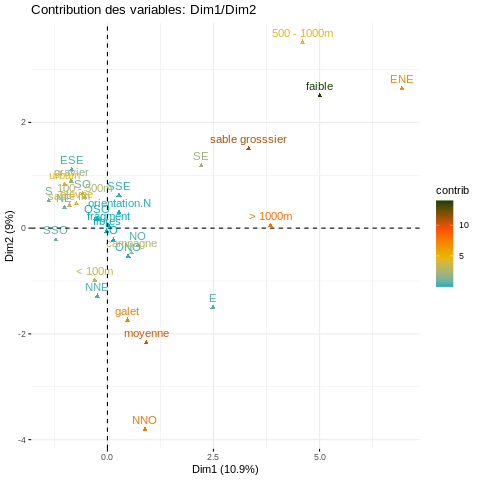

In [30]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, ncp = 5, graph=FALSE)

quali.var <- get_famd_var(factored, "quali.var")
fviz_famd_var(factored, "quali.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07", "#1B3E07"),
             title="Contribution des variables: Dim1/Dim2"
             )

### AFDM 2 dimensions

#### Valeurs Eigen et pourcentage cumulé de la variance

In [31]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, ncp = 2, graph=FALSE)

eig_val <- get_eigenvalue(factored)

print(eig_val)

      eigenvalue variance.percent cumulative.variance.percent
Dim.1   2.834187        10.900719                    10.90072
Dim.2   2.351375         9.043749                    19.94447


#### Contribution des variables à chaque dimension

In [32]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, ncp = 2, graph=FALSE)

var <- get_famd_var(factored)
var$contrib

                     Dim.1       Dim.2
compte         0.132171501  0.75577112
orientation   21.265266860 24.75551925
substrat      22.764649136 24.35576747
frequentation 26.739573670 29.13302885
situation      7.117996649  6.99872423
distance      21.975235000 13.94739065
objet          0.005107184  0.05379842


#### Les individus ayant des profils similaires sont proches les uns des autres sur la carte des facteurs.

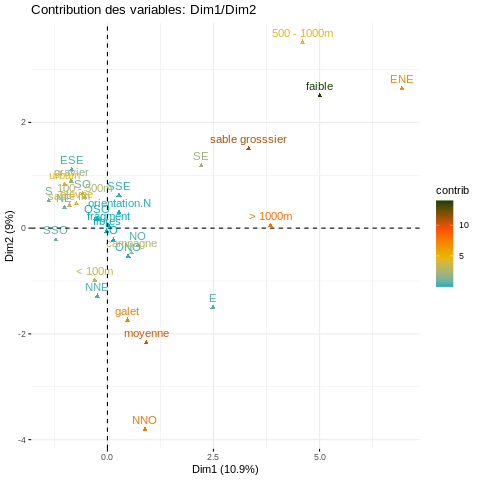

In [33]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, ncp = 2, graph=FALSE)

quali.var <- get_famd_var(factored, "quali.var")
fviz_famd_var(factored, "quali.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07", "#1B3E07"),
             title="Contribution des variables: Dim1/Dim2",
             )

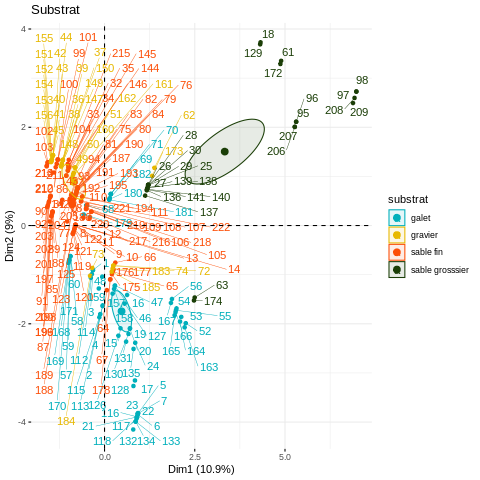

In [34]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, ncp = 2, graph=FALSE)

substrat <- fviz_mfa_ind(factored, 
             habillage = "substrat", # color by groups 
             palette = c("#00AFBB", "#E7B800", "#FC4E07", "#1B3E07"),
             addEllipses = TRUE, ellipse.type = "confidence", 
             repel = TRUE,
             title = "Substrat"
            
             )

substrat

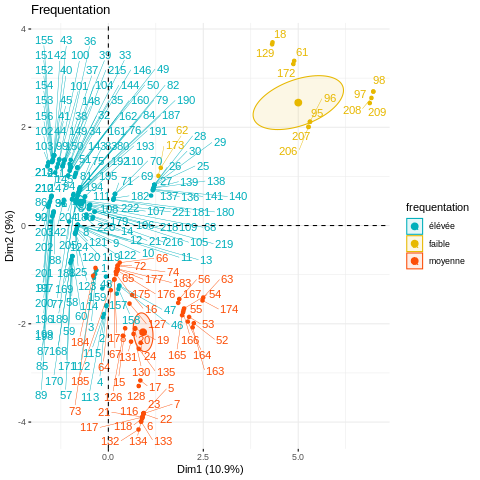

In [35]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, ncp = 2, graph=FALSE)

freq <- fviz_mfa_ind(factored, 
             habillage = "frequentation", # color by groups 
             palette = c("#00AFBB", "#E7B800", "#FC4E07", "#1B3E07"),
             addEllipses = TRUE, ellipse.type = "confidence", 
             repel = TRUE,
             title="Frequentation"
             
             )


freq

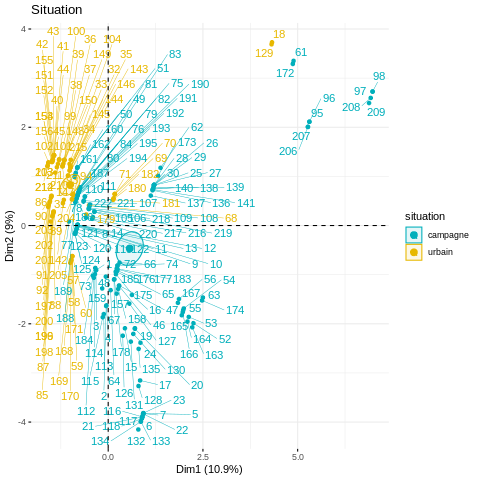

In [36]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, ncp = 2, graph=FALSE)

situation <- fviz_mfa_ind(factored, 
             habillage = "situation", # color by groups 
             palette = c("#00AFBB", "#E7B800", "#FC4E07", "#1B3E07"),
             addEllipses = TRUE, ellipse.type = "confidence", 
             repel = TRUE,
             title = "Situation"
             
             ) 



situation

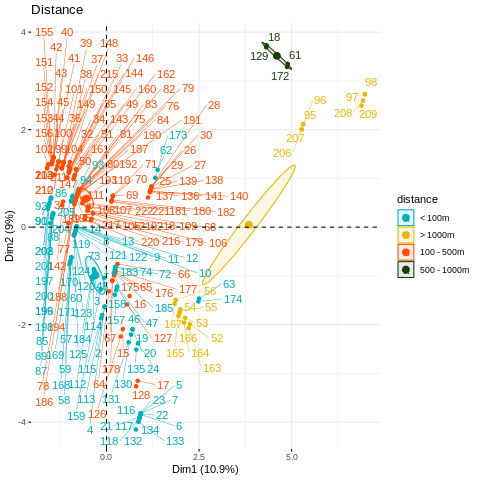

In [37]:
%%R
library(FactoMineR)
library(factoextra)
library(utils)
library(ggpubr)

data <- read.csv('data/end_pipe/long_form_combined_formes.csv')
factored <- FAMD(data, ncp = 2, graph=FALSE)

distance <- fviz_mfa_ind(factored, 
             habillage = "distance", # color by groups 
             palette = c("#00AFBB", "#E7B800", "#FC4E07", "#1B3E07"),
             addEllipses = TRUE, ellipse.type = "confidence", 
             repel = TRUE,
             title = "Distance"
            
                
             )


distance